# HOMEWORK PART 1

1. Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). Try also bagging the DMD to improve the results. See: https://github.com/duqbo/optdmd (MATLAB) and https://github.com/kunert/py-optDMD (Python)

2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. Try also bagging the DMD to improve the results.

3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d.

4. Find the best fit nonlinear, dynamical systems model to the data using bagging sparse regression SINDy (See: https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb)

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, splrep
from scipy.linalg import hankel
from scipy.integrate import solve_ivp

from sklearn.linear_model import Lasso, Ridge

from Utility.FunctionsDMD import DMD, DMDprediction, DMDtizio
from Utility.PythonBOPDMD.optimalDMD import optdmd
from Utility.lotkavolterra import LotkaVolterra

plt.style.use('science')

In [2]:
path = os.path.join("..", "Data", "Lynx-Snowshoe.csv")

data = pd.read_csv(path)

yr = data['Year']
sh = data['Snowshoe Hare Pelts(thousands)']
cl = data['Canadian Lynx Pelts(thousands)']

dt = 2

time = np.arange(0, max(yr) - min(yr) + dt, dt)

data.head()

,Year,Snowshoe Hare Pelts(thousands),Canadian Lynx Pelts(thousands)
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


# Request  n° 1

- Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). \
    Try also bagging the DMD to improve the results. See: 
    - https://github.com/duqbo/optdmd (MATLAB) 
    - https://github.com/kunert/py-optDMD (Python)

In [3]:
# Interpolation of the data series, the interpolation with the B-Splne function from SciPy have reasulted in some values lower than 0 replaced here with 1

sh_int = splrep(time, sh)
cl_int = splrep(time, cl)

dt = 0.1

yr_new = np.arange(min(yr), max(yr) + dt, dt)

t_new = np.arange(0, max(yr) - min(yr) + dt, dt)

sh_new = splev(t_new, sh_int)
tmp = sh_new <= 1
sh_new[tmp] = 1

cl_new = splev(t_new, cl_int)
tmp = cl_new <= 1
cl_new[tmp] = 1

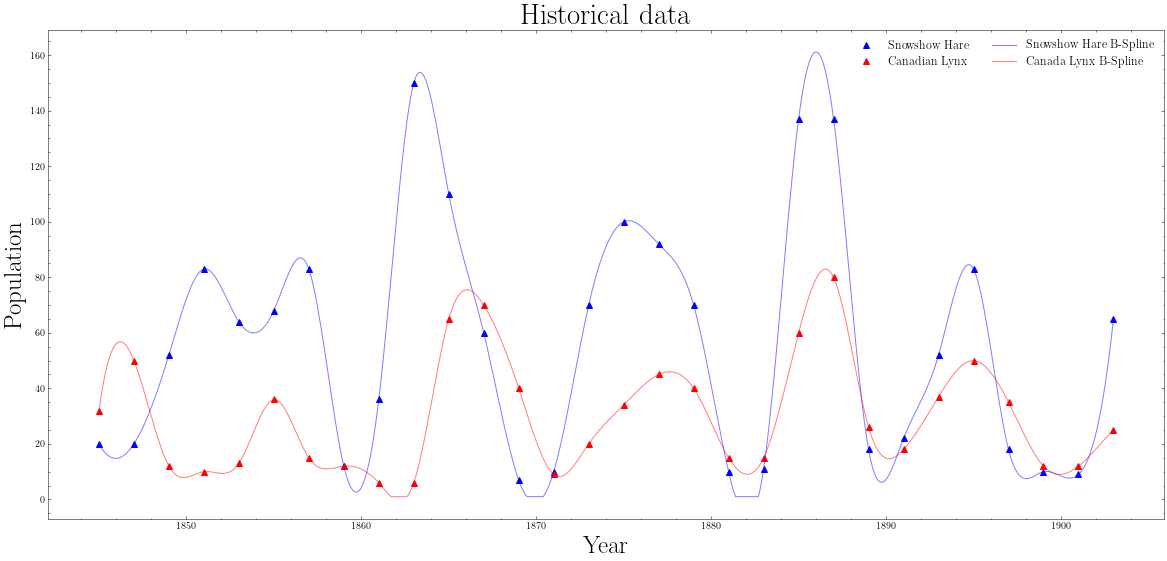

In [4]:
fig = plt.figure(figsize=(20, 9))

plt.plot(yr, sh, '^', linewidth='2', color='blue')
plt.plot(yr, cl, '^', linewidth='2', color='red') 
plt.plot(yr_new, sh_new, color='blue', alpha= 0.5)
plt.plot(yr_new, cl_new, color='red', alpha = 0.5)
plt.title('Historical data', fontsize = 29)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Population', fontsize = 25)
plt.legend(['Snowshow Hare', 'Canadian Lynx', 'Snowshow Hare B-Spline', 'Canada Lynx B-Spline'], fontsize = 12, ncol=2)

fig.savefig('Figures/population_data.pdf', format='pdf', dpi=1200)
plt.show()

## DMD on the real data-set

In [5]:
tmp_data = np.vstack((sh, cl))
X = tmp_data[:, :-1]
Xshift = tmp_data[:, 1:]

In [6]:
r = 2

Phi, Lambda, b = DMD(X,Xshift,r)

x_dmd = DMDprediction(Phi, Lambda, b, time,r)
    

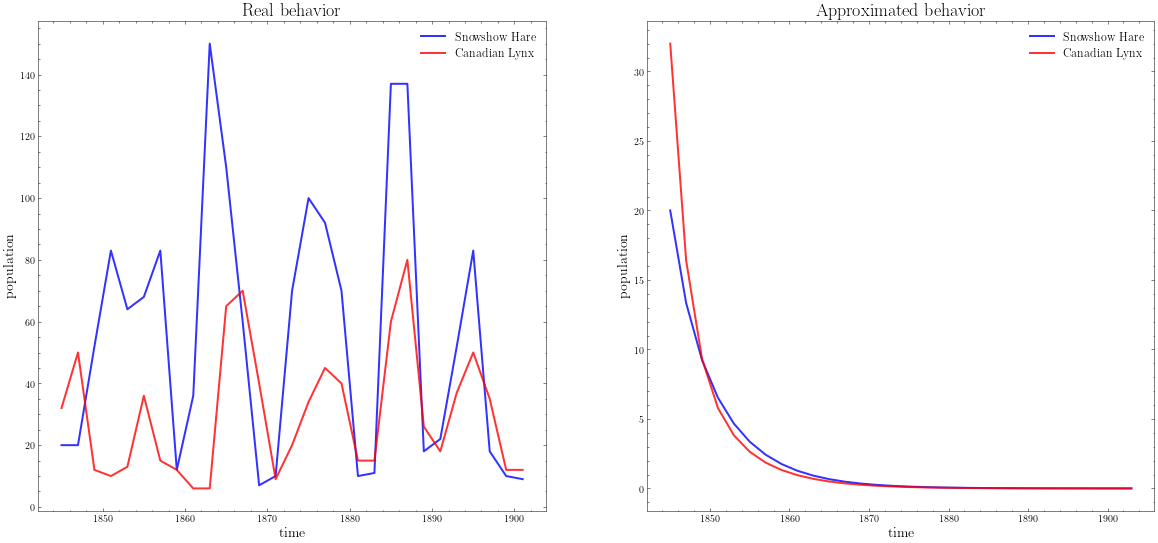

In [7]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/DMD_realset.pdf', format='pdf', dpi=1200)
plt.show()

## BOP-DMD on the real data-set

In [8]:
r = 2
imode = 2

X = tmp_data[:,:]

years = np.array(yr)
years = np.reshape(years, (1,len(years)))

w, e, b = optdmd(X,years,r,imode)

stall detected: residual reduced by less than 1e-12 
times residual at previous step. 
 teration 1 
current residual 0.9678015122048012


/home/tdinelli/anaconda3/envs/sindy/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/tdinelli/Documents/GitHub/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  djacout,jpvt,tau,_,_ = sla.lapack.zgeqp3(djacmat,work)
/home/tdinelli/Documents/GitHub/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  rhstop = sla.lapack.zunmqr('L','C',djacout,tau,res.ravel(order='F')[:,None],lwork)[0]


In [9]:
# RECONSTRUCTION OF THE PREDICTION

e_reshaped = np.reshape(e, (2,1))
x_dmd = w * np.diag(b) @ np.exp(e_reshaped * years)

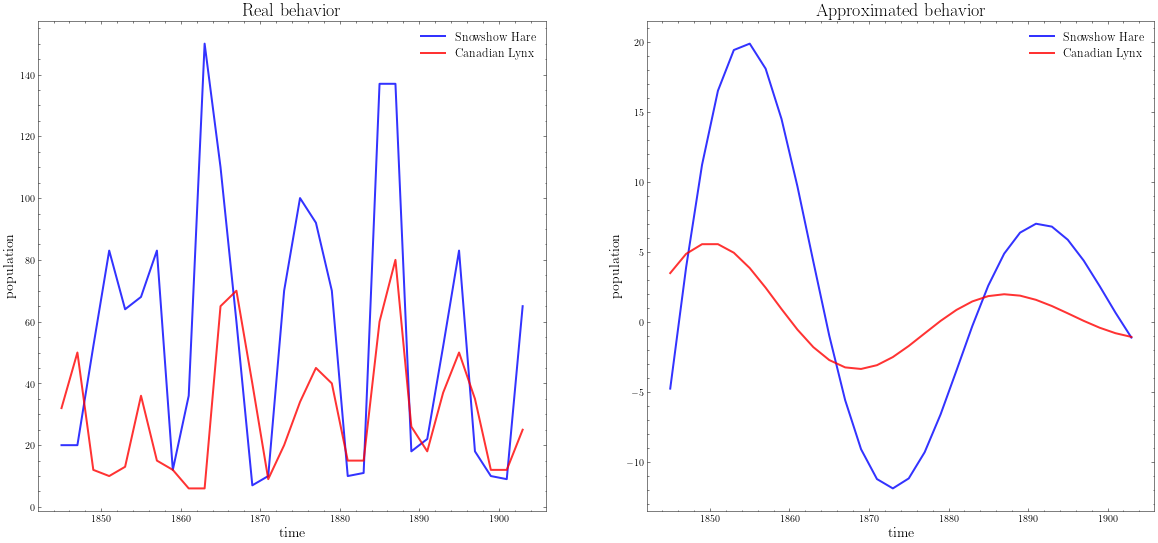

In [10]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr[:], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr[:], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/BOPDMD_realset.pdf', format='pdf', dpi=1200)
plt.show()

## DMD on the augmented data-set

In [11]:
# Repeting the same procedure with the interpolated data

tmp_data = np.vstack((sh_new, cl_new))

X = tmp_data[:, :-1]
Xshift = tmp_data[:, 1:]

In [12]:
r = 2
Phi, Lambda, b = DMD(X, Xshift, r)

x_dmd = DMDprediction(Phi, Lambda, b, yr_new,r)

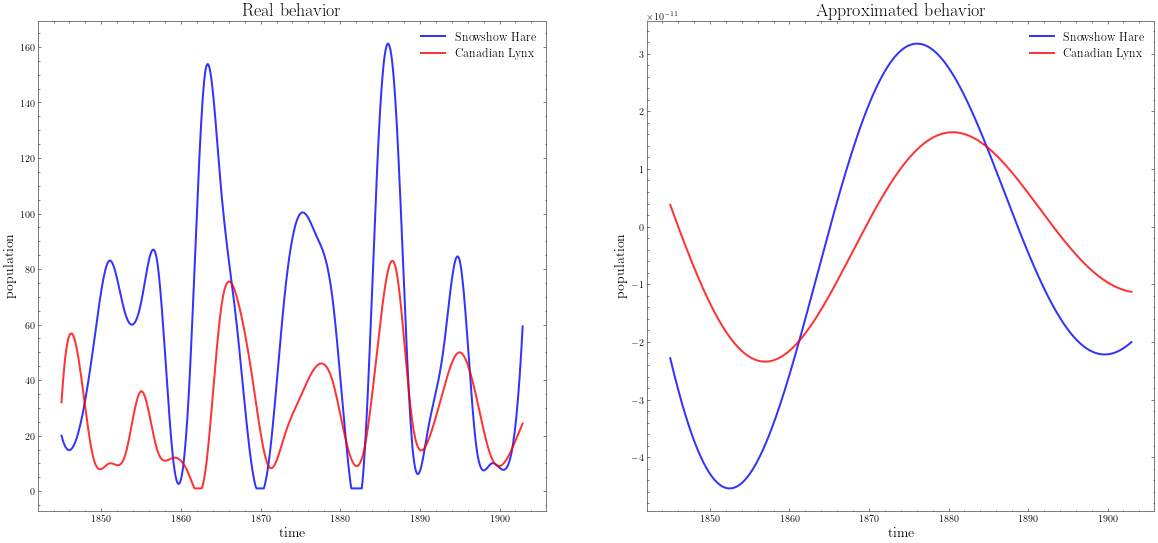

In [13]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr_new[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr_new, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/DMD_augmentedset.pdf', format='pdf', dpi=1200)
plt.show()

## BOP-DMD on the augmented data-set

In [14]:
r = 2
imode = 2

X = tmp_data[:,:]

years = np.array(yr_new)
years = np.reshape(years, (1,len(years)))

w, e, b = optdmd(X,years,r,imode)

stall detected: residual reduced by less than 1e-12 
times residual at previous step. 
 teration 1 
current residual 0.9766629726988647


In [15]:
# RECONSTRUCTION OF THE PREDICTION

e_reshaped = np.reshape(e, (2,1))
x_dmd = w * np.diag(b) @ np.exp(e_reshaped * years)

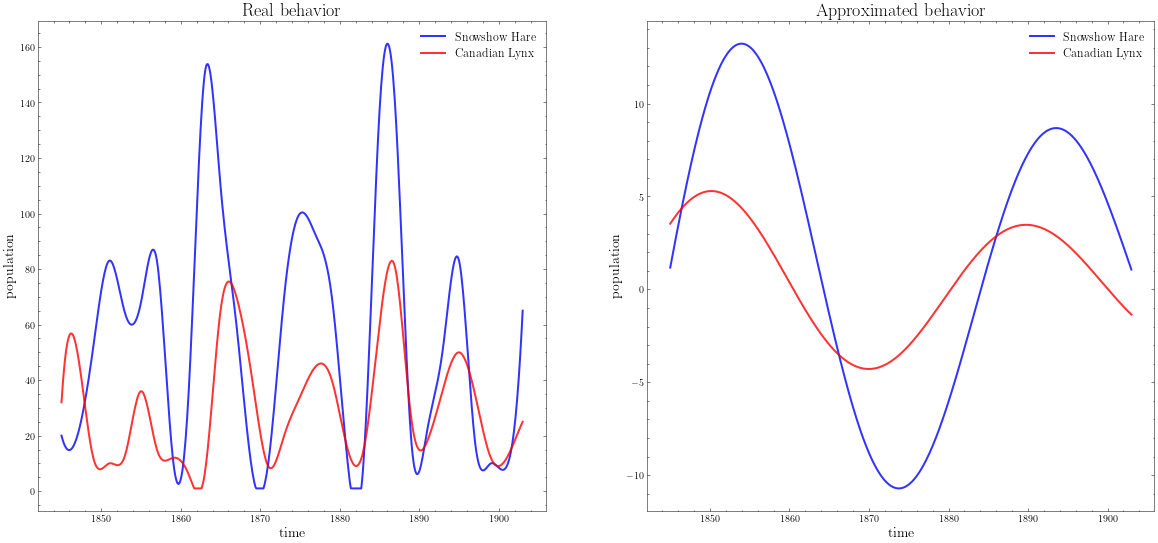

In [16]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr_new[:], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new[:], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr_new, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/BOPDMD_augmentedset.pdf', format='pdf', dpi=1200)
plt.show()

# Request n° 2
- Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. 
    - Try also bagging the DMD to improve the results.

In [17]:
# Initialize variables for the time delay

data = np.vstack((sh_new, cl_new))

t_start = 400
t_window = t_start
x_train = np.ones((100,)) * yr_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

## 10 delay Embeddings

In [18]:
n_emb = 10

X1 = data[:, :t_start]
X1_shift = data[:, 1:t_start+1]
for i in range(1, n_emb):
    X1 = np.vstack((X1, data[:,i:t_start+i]))
    X1_shift = np.vstack((X1_shift, data[:,i+1:t_start+i+1]))

## 100 delay Embeddings

In [19]:
n_emb = 100

X2 = data[:, :t_start]
X2_shift = data[:, 1:t_start+1]
for i in range(1, n_emb):
    X2 = np.vstack((X2, data[:,i:t_start+i]))
    X2_shift = np.vstack((X2_shift, data[:,i+1:t_start+i+1]))

## Full Embeddings

In [20]:
XX = hankel(data[:, :t_start])
X3_tmp = np.zeros_like(XX)
X3_tmp[0::2, :] = XX[:int(XX.shape[0]/2),:]
X3_tmp[1::2, :] = XX[int(XX.shape[0]/2):,:]
X3 = X3_tmp[:, :-1]
X3_shift = X3_tmp[:, 1:]

## SVD on the embeddings

In [21]:
u1, s1, v1 = np.linalg.svd(X1, full_matrices=False)
u2, s2, v2 = np.linalg.svd(X2, full_matrices=False)
u3, s3, v3 = np.linalg.svd(X3, full_matrices=False)

v1 = v1.conj().T
v2 = v2.conj().T
v3 = v3.conj().T

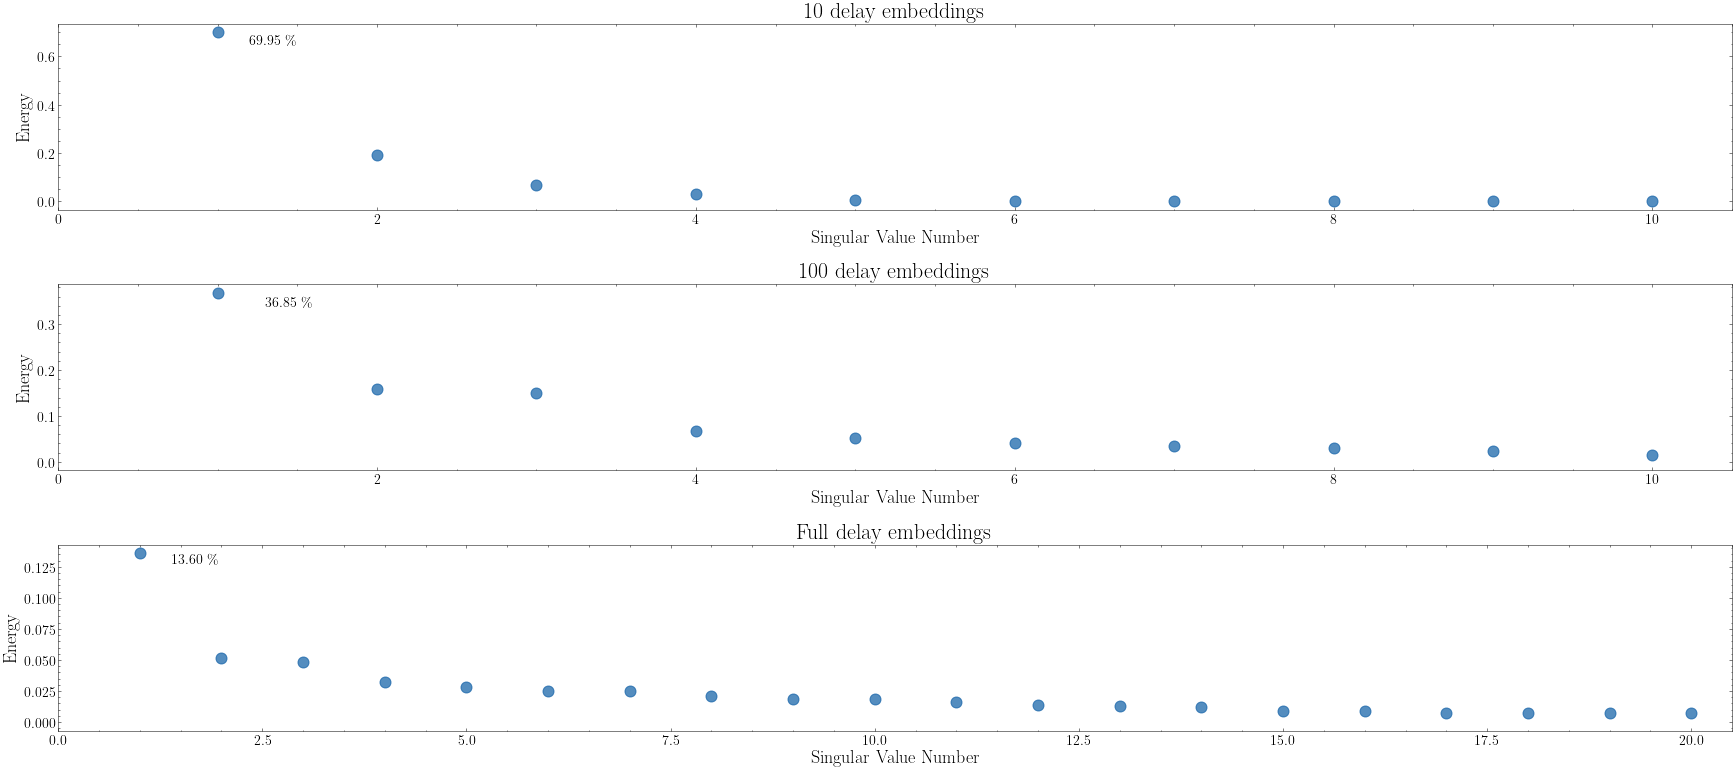

In [22]:
fig = plt.figure(figsize=(30, 13))

ax = plt.subplot(3, 1, 1)
ax.plot(range(1, len(s1)+1), s1 / np.sum(s1), 'o', markersize = 11, alpha = 0.7)
ax.set_title('10 delay embeddings', fontsize = 22)
ax.text(1.2, (s1[0] / np.sum(s1)) - 0.05, '{:6.2f} \%'.format(s1[0] / np.sum(s1) * 100), fontsize=14)
ax.set_xlim([0, 10.5])
ax.set_xlabel('Singular Value Number', fontsize = 18)
ax.set_ylabel('Energy', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 1, 2)
ax.plot(range(1, len(s2)+1), s2 / np.sum(s2), 'o', markersize = 11, alpha = 0.7)
ax.set_title('100 delay embeddings', fontsize = 22)
ax.text(1.3, (s2[0] / np.sum(s2)) - 0.03, '{:6.2f} \%'.format(s2[0] / np.sum(s2) * 100), fontsize=14)
ax.set_xlim([0, 10.5])
ax.set_xlabel('Singular Value Number', fontsize = 18)
ax.set_ylabel('Energy', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 1, 3)
ax.plot(range(1, len(s3)+1), s3 / np.sum(s3), 'o', markersize = 11, alpha = 0.7)
ax.set_title('Full delay embeddings', fontsize = 22)
ax.text(1.4, (s3[0] / np.sum(s3)) - 0.008, '{:6.2f} \%'.format(s3[0] / np.sum(s3) * 100), fontsize=14)
ax.set_xlim([0, 20.5])
ax.set_xlabel('Singular Value Number', fontsize = 18)
ax.set_ylabel('Energy', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(hspace=0.4)
fig.savefig('Figures/EmbeddingValues.pdf', format='pdf', dpi=1200)
plt.show()

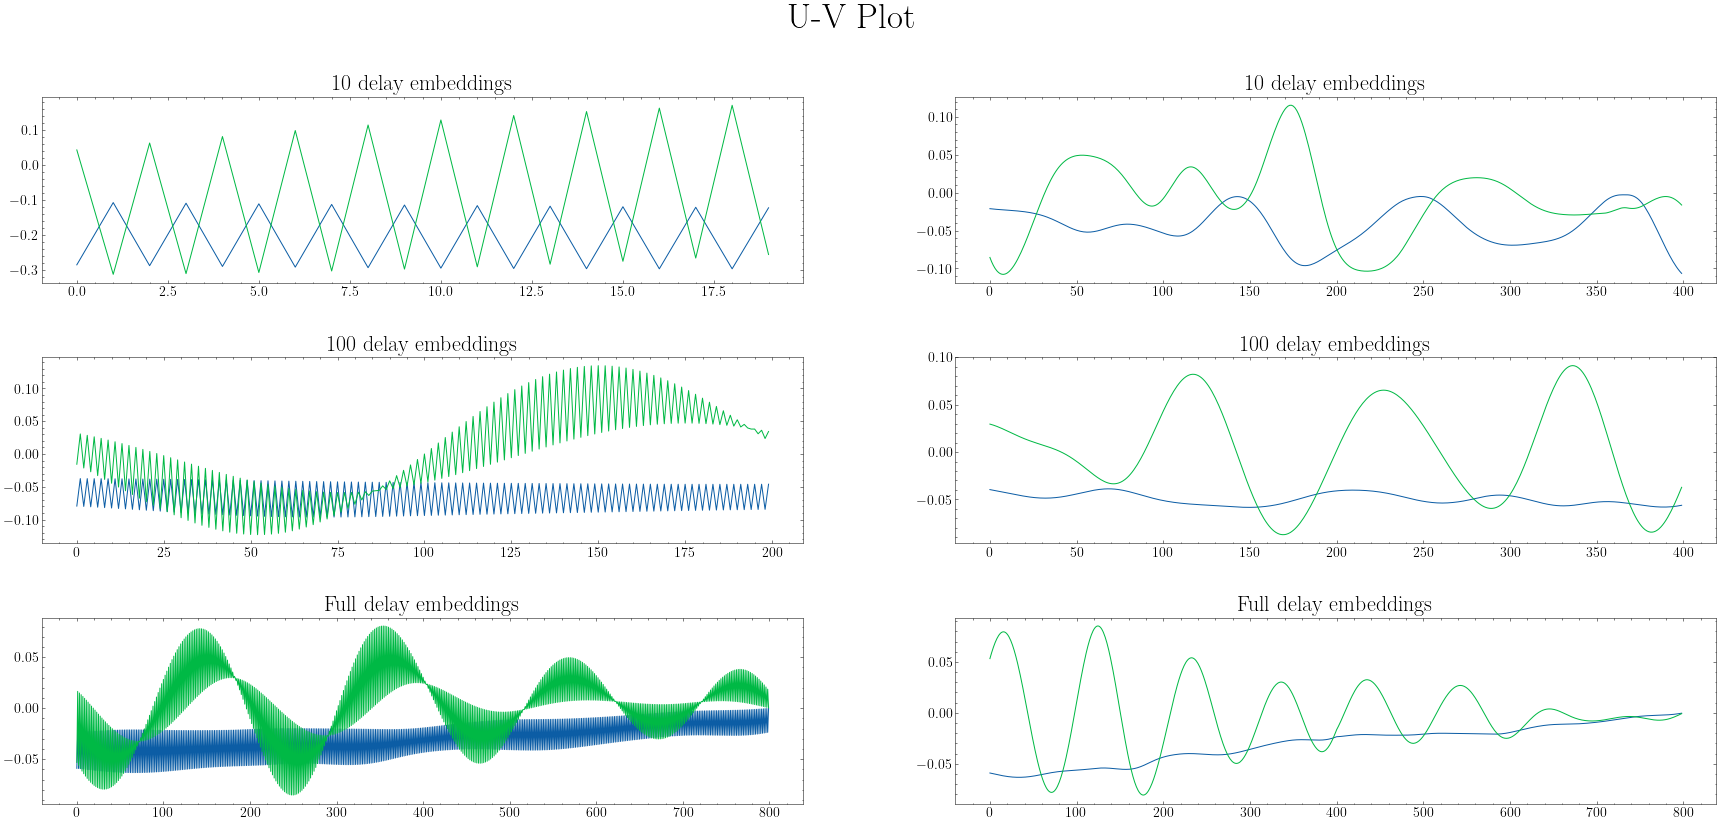

In [23]:
fig = plt.figure(figsize=(30, 13))
fig.suptitle("U-V Plot", fontsize = 35)

ax = plt.subplot(3, 2, 1)
ax.plot(u1[:, 0])
ax.plot(u1[:, 1])
ax.set_title('10 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 3)
ax.plot(u2[:, 0])
ax.plot(u2[:, 1])
ax.set_title('100 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 5)
ax.plot(u3[:, 0])
ax.plot(u3[:, 1])
ax.set_title('Full delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 2)
ax.plot(v1[:, 0])
ax.plot(v1[:, 1])
ax.set_title('10 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 4)
ax.plot(v2[:, 0])
ax.plot(v2[:, 1])
ax.set_title('100 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 6)
ax.plot(v3[:, 0])
ax.plot(v3[:, 1])
ax.set_title('Full delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
fig.savefig('Figures/U-V_plot.pdf', format='pdf', dpi=1200)
plt.show()

## DMD to forecast the dynamics of the system

In [24]:
r = 4
U1, S1, V1, X1pred = DMDtizio(X1,X1_shift,r,t_new)

r = 10
U2, S2, V2, X2pred = DMDtizio(X2,X2_shift,r,t_new)

r = 40
U3, S3, V3, X3pred = DMDtizio(X3,X3_shift,r,t_new)

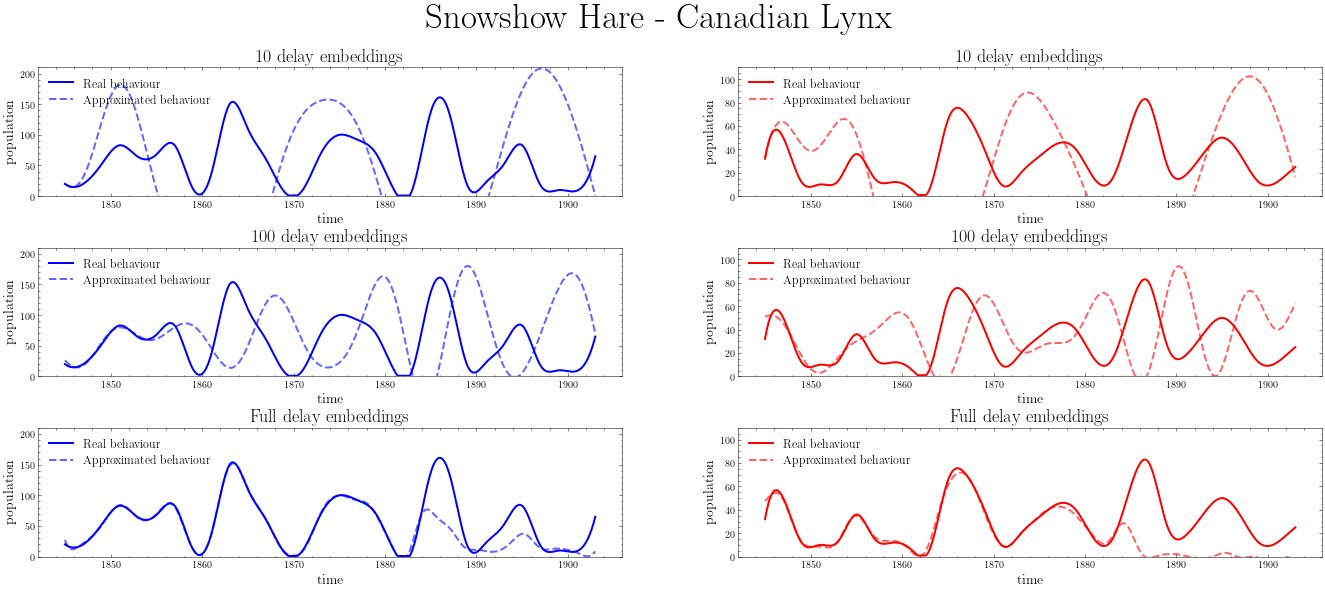

In [25]:
fig = plt.figure(figsize=(23, 9))

plt.suptitle('Snowshow Hare - Canadian Lynx', fontsize = 35)
ax = plt.subplot(3,2,1)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X1pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('10 delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,2)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X1pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('10 delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,3)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X2pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('100 delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,4)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X2pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('100 delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,5)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X3pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('Full delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,6)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X3pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('Full delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

plt.subplots_adjust(hspace=0.4)
plt.show()

## BOP-DMD trying to improve the results

# Request n° 3

Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d.

In [26]:
dt = 0.1
years = yr_new
t = t_new

X1 = np.vstack((sh_new, t)) # Snowshoe
X2 = np.vstack((cl_new, t)) # Canadian Lynx

print(len(t))

581


In [27]:
X1dot = np.zeros(X1.shape)
X2dot = np.zeros(X2.shape)

for i in range(1, len(t) - 1):
    X1dot[0,i] = (X1[0, i+1] - X1[0, i-1]) / (2 * dt)
    X1dot[1,i] = X1[1, i+1] - X1[1,i-1]
    
    X2dot[0,i] = (X2[0, i+1] - X2[0, i-1]) / (2 * dt)
    X2dot[1,i] = X2[1, i+1] - X2[1,i-1]

X1dot_res = np.reshape(X1dot, (X1dot.shape[1], 2))
X2dot_res = np.reshape(X2dot, (X2dot.shape[1], 2))

In [28]:
model_1 = Ridge(alpha=0.1, solver='lsqr')
model_2 = Ridge(alpha=0.1, solver='lsqr')

sh_fit = model_1.fit(X1dot_res, t)
cl_fit = model_2.fit(X2dot_res, t)

In [29]:
b = sh_fit.coef_[0]
p = sh_fit.coef_[1]
r = cl_fit.coef_[0]
d = cl_fit.coef_[1]

print(b, p, r, d)

# b = 0.25735907182891354
# p = 0.00536310210545759
# d = 0.36899578596748844
# r = 0.0034560613764398657

-0.010243739338998116 -0.009939750639527801 0.3290402519749818 -0.29720903723625797


In [30]:
x0 = [X1[0,0], X2[0,0]]
t_test = np.arange(t[0], t[-1]+0.1, 0.1)
sol = solve_ivp(LotkaVolterra, 
        [t[0], t[-1]], 
        x0, 
        args=(b, p, d, r),
        t_eval = t_test, 
        method = 'RK45')
t1 = sol['t']
sol = np.vstack((sol['y'][0], sol['y'][1]))

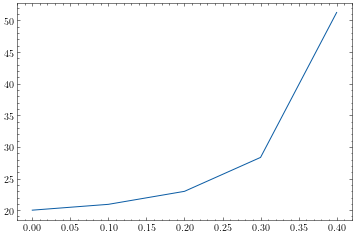

In [31]:
# plt.plot(t_test, sol[:,0])

plt.plot(t1, sol[0,:])
